In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Prepare basic parameters

In [5]:
# define the years to be classified
year_name  = [f'{i}_{i+2}' for i in range(1990,2020,3)]

# define the number of total periods
num_invarient = 10

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
year_name

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

##### Prepare input_image for classification

In [7]:
# prepare the climate data
Climate_type = ['lrad','prec','pres','shum','srad','temp','wind']
Climate_mean = []

for year in range(1990,2019,3):   
    
    # define the three years according to year-variable
    year_start = year
    year_mid   = year + 1
    year_end   = year + 2
    
    # Initiate an empty list to hold the climate-tifs-mean from year_start to year_end
    climate_tifs_mean = []
    
    # compute the mean-tif of each climate-type
    for i in Climate_type:

        # Because cliate_data doesn't include data of 2019, so 
        # use if-else judgement to exclede the data of year 2019
        if year < 2017:
            climate_tifs = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/Climate_data/{i}/{i}_{t}")                        
                            for t in [year_start,year_mid,year_end]]
            tifs_mean    = ee.ImageCollection(climate_tifs).mean().toFloat().rename(i)

        else:
            climate_tifs = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/Climate_data/{i}/{i}_{t}")                        
                            for t in [year_start,year_mid]]

            tifs_mean    = ee.ImageCollection(climate_tifs).mean().toFloat().rename(i)

        # add all climate_tifs_mean of year_start to year_end to list
        climate_tifs_mean.append(tifs_mean)
        climate_tifs_mean_img = ee.Image(climate_tifs_mean)
        

    # add the mean-cliamte-img into the Climate_mean
    Climate_mean.append(climate_tifs_mean_img)

In [8]:
# import Landsat img
Landsat_img = [ee.Image(f"users/wang8052664/Cloud_Free_Img/Landsat_cloud_free_{year}")\
                 .clip(North_China_Plain)  for year in year_name]

# import Fourier img   
Fourier_img = [ee.Image(f"users/Jinzhu_Deakin/North_China_Plain/Fourier_img_harmonic_3/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[:5]] + \
              [ee.Image(f"users/wang8052664/North_China_Plain/Fourier_imgs/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[5:]] 

# Import the Index-mean Img
NDVI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDVI").rename('Mean_NDVI')  
            for year in year_name ]
NDBI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_NDBI").rename('Mean_NDBI')  
            for year in year_name ]
EVI_img  = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{year}_Mean_EVI").rename('Mean_EVI')  
            for year in year_name ]

# Import DEM/SLOPE Img
DEM   = [ee.Image("USGS/SRTMGL1_003").rename('DEM')] * num_invarient
SLOPE = [ee.Terrain.slope(DEM).rename('SLOPE')] * num_invarient

In [9]:
# stack all Imput_Img together
Stack_img = [ee.Image(img) for img in zip(Landsat_img,Fourier_img,NDVI_img,NDBI_img,EVI_img,Climate_mean,DEM,SLOPE)]

##### Prepare input sample points

In [10]:
# Define the path to Sample_pt
path = 'users/wangjinzhulala/North_China_Plain_Python/Sample_extract_img'

# Get the training sample
Training_sample = [ee.FeatureCollection(f"{path}/Control_sample_ext_img_{year}")
                     for year in year_name]

##### Stack input_img and input_sample together

In [11]:
# first put all inputs together
stack_name   = ['Control'] * num_invarient

stack_year   = year_name 
stack_img    = Stack_img 
stack_sample = Training_sample 

# stack all ingredients together
Stack_img_sample = list(zip(stack_name,stack_year,stack_img,stack_sample))

#### Create the classification instances

In [12]:
# A two-layer loop to generate 10-randome-split layers for each year-period

Classificatioin_result = []

# The first-layer loop to go througth each year-periods
for input_variable in Stack_img_sample:
    
    classificaiton_tpye = input_variable[0]
    year                = input_variable[1]
    input_img           = input_variable[2]
    sample_pt           = input_variable[3]    
    input_band          = input_img.bandNames().getInfo()

    # The second-layer to go through each-randomnes
    for seed in range(10):
        
        # Instatiate the class with a name.
        classification = Classification(year_name      = year,
                                        Verified_point = sample_pt,
                                        Input_img      = input_img,
                                        Input_band     = input_band,
                                        Tree_num       = 50,
                                        seed           = seed,
                                        Zone_sample    = None,
                                        classProperty  = 'Built')


        # perform the classification on Input_img and Samples
        classification.Stp_1_Classification_on_img()
        classification.Stp_2_Classification_on_Samples()
        
        # Get the Random-Forest Classifier
        classifier = classification.classifier

        # Get the classified img
        classified_img = classification.classification_img
        # add a randomcolum for the traning points as an inputband,
        # so we can see which band is important by comparing to randomband
        classifier_randoncolumn = ee.Classifier.smileRandomForest(numberOfTrees = 100)\
                                               .train(features        = sample_pt.randomColumn(),
                                                      inputProperties = [i for i in list(sample_pt.randomColumn().limit(1)\
                                                                                         .getInfo()['columns'].keys()) 
                                                                         if i not in ['Built','system:index']],
                                                      classProperty   = 'Built')

        # Get the classified samples
        train_sample_classified = classification.Train_sample_classification
        test_sample_classified  = classification.Test_sample_classification

        # add classfication into the list
        Classificatioin_result.append((classificaiton_tpye,year,seed,classified_img,test_sample_classified,
                                       classifier,classifier_randoncolumn))

In [14]:
# convert classificaiton instances into a dataframe
Classification_instances_df =  pd.DataFrame(Classificatioin_result,
                                            columns=['classificaiton_tpye','year','seed','classified_img',
                                                     'test_sample_classified','classifier','classifier_randoncolumn'])
Classification_instances_df

,classificaiton_tpye,year,seed,classified_img,test_sample_classified,classifier,classifier_randoncolumn
0,Control,1990_1992,0,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
1,Control,1990_1992,1,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
2,Control,1990_1992,2,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
3,Control,1990_1992,3,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
4,Control,1990_1992,4,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
...,...,...,...,...,...,...,...
95,Control,2017_2019,5,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
96,Control,2017_2019,6,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
97,Control,2017_2019,7,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
98,Control,2017_2019,8,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."


#### Calculate the importance of each input band

In [33]:
Importance_dict = {}

# calculate the accuracy of differnet randomness
for index, row in Classification_instances_df.iterrows():
    
    # get the year and seed perperties
    year = row[1]
    seed = row[2]
    
    # fetch the importance dictionary
    impt = row[6].explain().get('importance').getInfo()

    # add importance value to Importance_df
    Importance_dict[(year,seed)] = impt
    
    # print out the process
    print(f'{year}_{seed} importance computation complete!')

1990_1992_0 importance computation complete!
1990_1992_1 importance computation complete!
1990_1992_2 importance computation complete!
1990_1992_3 importance computation complete!
1990_1992_4 importance computation complete!
1990_1992_5 importance computation complete!
1990_1992_6 importance computation complete!
1990_1992_7 importance computation complete!
1990_1992_8 importance computation complete!
1990_1992_9 importance computation complete!
1993_1995_0 importance computation complete!
1993_1995_1 importance computation complete!
1993_1995_2 importance computation complete!
1993_1995_3 importance computation complete!
1993_1995_4 importance computation complete!
1993_1995_5 importance computation complete!
1993_1995_6 importance computation complete!
1993_1995_7 importance computation complete!
1993_1995_8 importance computation complete!
1993_1995_9 importance computation complete!
1996_1998_0 importance computation complete!
1996_1998_1 importance computation complete!
1996_1998_

Formatting the importance_df

In [34]:
# put importance_dict into a dataframe
Importance_df = pd.DataFrame(Importance_dict)

# unstack the dataframe into single indexed dataframes
Importance_df_single_index = pd.DataFrame(Importance_df.unstack(1)).reset_index([0,1,2])
Importance_df_single_index.columns = ['year','seed','band','importance']

# Make the year column categorical so we can make figures
Importance_df_single_index['year'] = pd.Categorical(Importance_df_single_index['year'])

Exporting the importance_df

In [15]:
# # export the df to local disk
# Importance_df_single_index.to_csv('Step_2_Result\Importance_Landsat_random_1990_2019.csv',index=False)

# read the df from locak disk
Importance_df_single_index = pd.read_csv('Step_2_Result\Importance_Landsat_random_1990_2019.csv')
Importance_df_single_index['year'] = pd.Categorical(Importance_df_single_index['year'])


In [18]:
# calculaten the average importance of each band so we can have a proper order for figs
gourp_mean = Importance_df_single_index.groupby('band').mean().sort_values('importance',ascending=False)

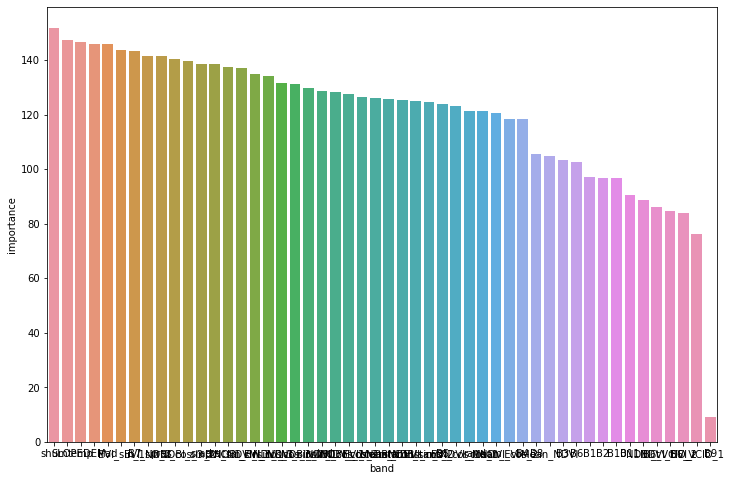

In [17]:
plt.figure(figsize=(12,8))
sns.barplot(x=gourp_mean.index ,y ='importance', data=gourp_mean )

#### Add one of the classified img to map

In [22]:
one = Classification_instances_df.iloc[0][3]
one

In [23]:
Full_sample_classified_img = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Random_1990_1992")\
                               .sum()

In [24]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(one,{'min':0,'max':1},'One')
Map.addLayer(Full_sample_classified_img,{'min':0,'max':1},'Full_sample_classified_img')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

#### calculate the accuracy of each radomness

In [25]:
acc = []

# calculate the accuracy of differnet randomness
for i in Classificatioin_result:
    
    accuracy = Accuracy_assesment(i[4]).Stp_1_Calculate_Accuracy()
    acc.append(accuracy)
    
    key = 'Recall_built'
    print(f'{i[1]}_{i[2]}-->Recall_built:{accuracy[key]}')

1990_1992_0-->Recall_built:93.22
1990_1992_1-->Recall_built:94.86
1990_1992_2-->Recall_built:94.83
1990_1992_3-->Recall_built:93.6
1990_1992_4-->Recall_built:95.07
1990_1992_5-->Recall_built:94.99
1990_1992_6-->Recall_built:95.26
1990_1992_7-->Recall_built:95.27
1990_1992_8-->Recall_built:95.06
1990_1992_9-->Recall_built:95.78
1993_1995_0-->Recall_built:93.98
1993_1995_1-->Recall_built:93.94
1993_1995_2-->Recall_built:94.55
1993_1995_3-->Recall_built:93.35
1993_1995_4-->Recall_built:93.74
1993_1995_5-->Recall_built:93.41
1993_1995_6-->Recall_built:94.15
1993_1995_7-->Recall_built:94.24
1993_1995_8-->Recall_built:93.81
1993_1995_9-->Recall_built:93.7
1996_1998_0-->Recall_built:93.6
1996_1998_1-->Recall_built:94.48
1996_1998_2-->Recall_built:94.8
1996_1998_3-->Recall_built:93.89
1996_1998_4-->Recall_built:92.9
1996_1998_5-->Recall_built:94.92
1996_1998_6-->Recall_built:94.5
1996_1998_7-->Recall_built:94.25
1996_1998_8-->Recall_built:91.37
1996_1998_9-->Recall_built:93.56
1999_2001_0-->Re

In [31]:
# # store the acc_df to local drive
# acc_df = pd.concat([Classification_instances_df[['year','seed']],pd.DataFrame(acc)],axis=1)
# acc_df.to_csv('./Step_2_Result/Randome_Control_Accuracy_tree_50.csv',index=False)

# access the acc_df
acc_df = pd.read_csv('./Step_2_Result/Randome_Control_Accuracy_tree_50.csv')
acc_df

,year,seed,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,1990_1992,0,94.04,93.31,94.80,94.87,93.22
1,1990_1992,1,94.84,94.58,95.09,94.82,94.86
2,1990_1992,2,94.60,94.43,94.76,94.35,94.83
3,1990_1992,3,94.20,93.78,94.64,94.79,93.60
4,1990_1992,4,94.86,94.90,94.83,94.65,95.07
...,...,...,...,...,...,...,...
95,2017_2019,5,92.31,92.13,92.50,92.81,91.79
96,2017_2019,6,92.63,92.42,92.84,93.12,92.12
97,2017_2019,7,92.47,92.08,92.88,93.16,91.76
98,2017_2019,8,92.76,92.05,93.51,93.70,91.81


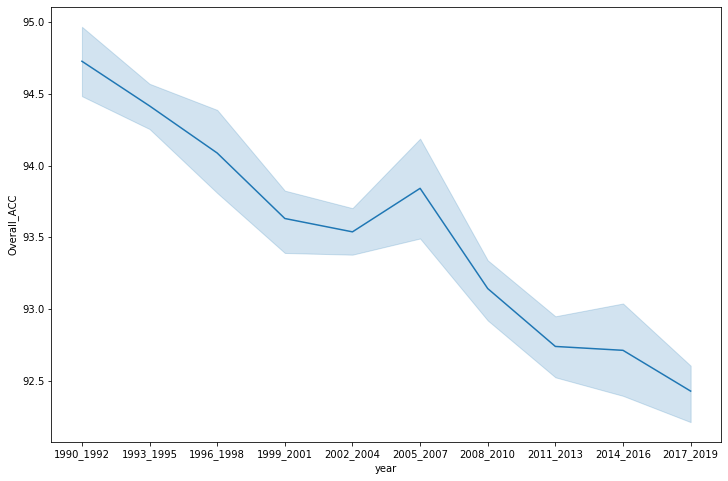

In [32]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='Overall_ACC',data=acc_df)

##### Export the classified_img

In [21]:
for item in Classificatioin_result:
     
    Classification_type = item[0]
    year = item[1]
    seed = item[2]
    img  = item[3]
    
    
    export_name = f'{Classification_type}_{year}_{seed}'
    
#     # export to Google Storage
#     task = ee.batch.Export.image.toCloudStorage(image          = img,
#                                                 description    = export_name,
#                                                 bucket         = 'north_china_plain',
#                                                 fileNamePrefix = export_name,
#                                                 region         = North_China_Plain.geometry().bounds(),
#                                                 scale          = 30,
#                                                 maxPixels      = int(1e13),
#                                                 skipEmptyTiles = True)
    
    #export to GEE asset
    asset_path = f'users/wangjinzhulala/North_China_Plain_Python/Climate_data'
    
    task = ee.batch.Export.image.toAsset(   image          = img,
                                            description    = export_name,
                                            assetId        = f'{asset_path}/{export_name}',
                                            region         = North_China_Plain.geometry().bounds(),
                                            scale          = 30,
                                            maxPixels      = int(1e13)) 
    
    task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting Control_1990_1992_0 successful!
Exporting Control_1990_1992_1 successful!
Exporting Control_1990_1992_2 successful!
Exporting Control_1990_1992_3 successful!
Exporting Control_1990_1992_4 successful!
Exporting Control_1990_1992_5 successful!
Exporting Control_1990_1992_6 successful!
Exporting Control_1990_1992_7 successful!
Exporting Control_1990_1992_8 successful!
Exporting Control_1990_1992_9 successful!
Exporting Control_1993_1995_0 successful!
Exporting Control_1993_1995_1 successful!
Exporting Control_1993_1995_2 successful!
Exporting Control_1993_1995_3 successful!
Exporting Control_1993_1995_4 successful!
Exporting Control_1993_1995_5 successful!
Exporting Control_1993_1995_6 successful!
Exporting Control_1993_1995_7 successful!
Exporting Control_1993_1995_8 successful!
Exporting Control_1993_1995_9 successful!
Exporting Control_1996_1998_0 successful!
Exporting Control_1996_1998_1 successful!
Exporting Control_1996_1998_2 successful!
Exporting Control_1996_1998_3 succ